In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
dataset_path='/home/raghav/Documents/Python/research files/Bengaluru_House_Data.csv'
df = pd.read_csv(dataset_path)
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Fixing Dataset

In [217]:
df2 = df.drop(['area_type','availability','society','balcony'], axis='columns')
df2.head(2)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00


In [218]:
df2.dropna(subset = ["location"], inplace=True)

In [219]:
def is_null(df):
    for i in df.columns:
        df.dropna(subset=[i], inplace=True)
    return df  
df3 = is_null(df2)

df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [220]:
def fix_size(df):
    df['size']= df['size'].apply(lambda x: int(x.split(" ")[0]))
    return df
df4 = fix_size(df3)
df4['size'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [221]:
df4['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [222]:
def fix_total_sqft(x):
    token = x.split("-")
    if len(token) == 2:
        return ((float(token[0]))+(float(token[1])))/2
    try:
        return float(x)
    except:
        return None
df4['total_sqft'] = df4['total_sqft'].apply(fix_total_sqft)
def is_null(df):
    for i in df.columns:
        df.dropna(subset=[i], inplace=True)
    return df  
df4 = is_null(df4)

In [223]:
# Implementing price per sqft
def is_pps(df):
    df['pps'] = df['price']*100000 / df['total_sqft']
    return df
df5 = is_pps(df4)
df5.head()
df5.shape

(13200, 6)

In [224]:
#fixing location
location_stat = df5.groupby('location')['location'].agg("count")
location_stat = location_stat[location_stat<11]

def fix_location_stat(df):
    df['location'] = df['location'].apply(lambda x:"other" if x in location_stat else x)
    return df
df6 = fix_location_stat(df5)
print(df6.shape)


(13200, 6)


Working with outliers

In [225]:
# total_sqft/bhk < 300
df7 = df6[~(df6['total_sqft']/df6['size'] < 300)]
df7.shape

(12456, 6)

In [226]:
df7.pps.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: pps, dtype: float64

In [227]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.pps)
        st = np.std(subdf.pps)
        reduced_df = subdf[(subdf.pps>(m-st)) & (subdf.pps<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df8 = remove_pps_outliers(df7)
df8.shape

(10245, 6)

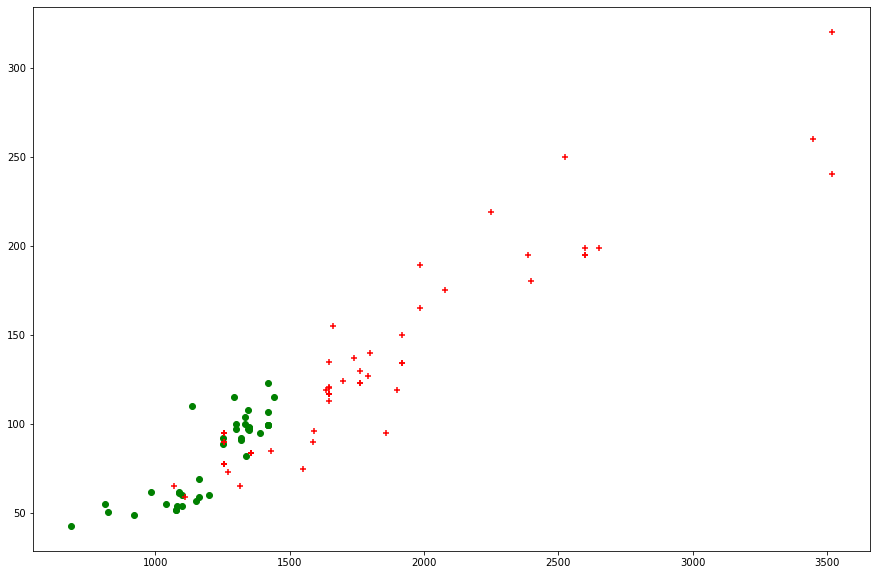

In [228]:
def scatter_plot(df,location):
    bhk2 = df[(df.location == location ) & (df['size']==2)]
    bhk3 = df[(df.location == location ) & (df['size']==3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color="green")
    plt.scatter(bhk3.total_sqft, bhk3.price, color="red", marker="+")
scatter_plot(df8, "Hebbal")

In [229]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('size'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.pps),
                'std': np.std(bhk_df.pps),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('size'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.pps<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df9 = remove_bhk_outliers(df8)
# df8 = df7.copy()
df9.shape

(7331, 6)

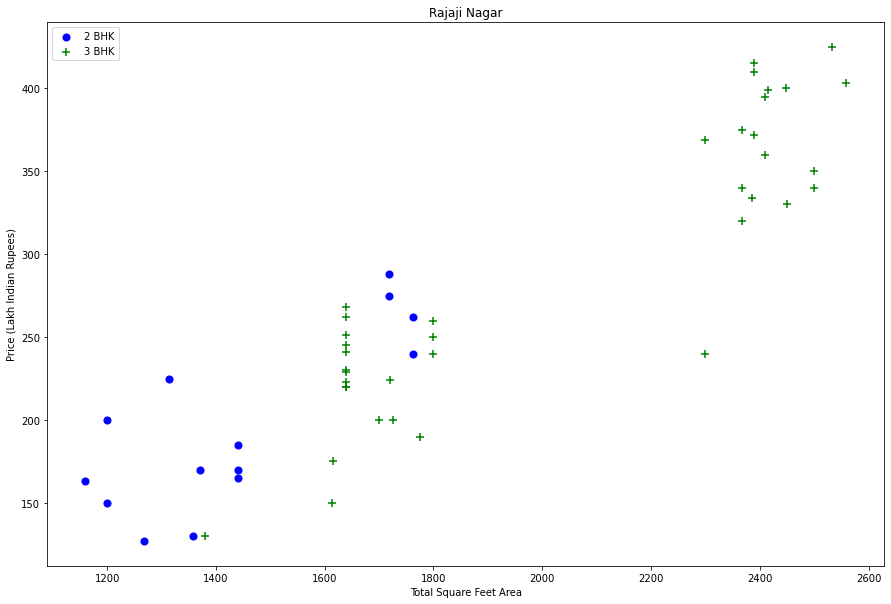

In [230]:
plot_scatter_chart(df8,"Rajaji Nagar")

In [231]:
df10 = df9[df9.bath<df9['size']+2]
df10.shape

(7253, 6)

In [232]:
dummie = pd.get_dummies(df10.location)
dummie = dummie.drop('other', axis="columns")
df11 = pd.concat([df10,dummie], axis = "columns")

In [286]:
df12 = df11.drop(['location','pps'], axis="columns")
df12.head()

,size,total_sqft,bath,price,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,2,1250.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1200.0,2.0,83.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1170.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1425.0,2.0,65.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,947.0,2.0,43.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
df12.shape

(7253, 244)

In [288]:
x = df12.drop('price', axis="columns")
y = df12.price

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)


In [289]:
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test,y_test)

0.7780866051090543

In [290]:
x.columns

Index(['size', 'total_sqft', 'bath', ' Devarachikkanahalli',
       '1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [291]:
def predict_price(location,total_sqft,bath,size):    
    loc_index = np.where(x.columns==location)[0][0]

    result = np.zeros(len(x.columns))
    result[0] = size
    result[1] = total_sqft
    result[2] = bath
    if loc_index >= 0:
        result[loc_index] = 1

    return reg.predict([result])[0]

In [296]:
predict_price('Indira Nagar',1000, 3, 3)

193.2128874234278

In [297]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(reg,f)

import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))